https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/#comment-442845

In [18]:
from datetime import datetime

from keras import Sequential
from keras.layers import Dense, LSTM
from matplotlib import pyplot as plt
from pandas import concat, DataFrame, read_csv
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

%matplotlib inline

In [2]:
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

In [4]:
data = read_csv('../data/BeijingPollution.csv', 
                parse_dates=[['year', 'month', 'day', 'hour']],
                index_col=0,
                date_parser=parse)
data.drop('No', axis=1, inplace=True)
data.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 
                'wnd_spd', 'snow', 'rain']
data.index.name = 'date'
data['pollution'].fillna(0, inplace=True)
data = data[24:] # drop first 24 hours
data.to_csv('../data/BeijingPollutionClean.csv')
data.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


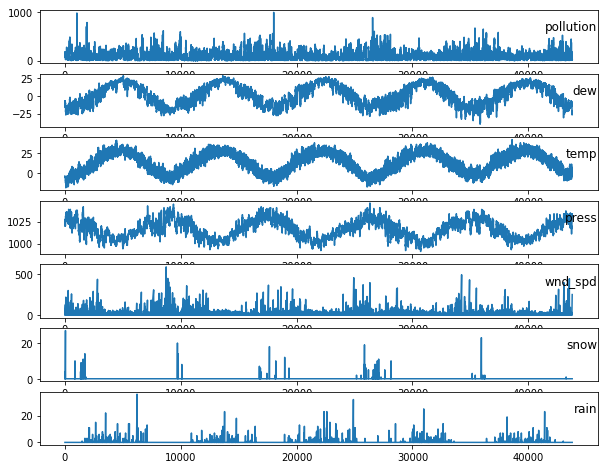

In [5]:
values = data.values
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
plt.figure(figsize=(10, 8))

for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(data.columns[group], y=0.5, loc='right')
    i += 1

# Data Prep

In [6]:
# Convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
    # input seq (t - n, ..., t - 1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
        
    # forecast seq (t, t + 1, ..., t + n)
    for i in range(n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for i in range(n_vars)]
            
    # combine
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # Drop nan rows
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [7]:
# Integer encode wind direction
encoder = LabelEncoder()
values[:, 4] = encoder.fit_transform(values[:, 4])
values = values.astype('float32')

In [8]:
# Normalize (min-max)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [1]:
# Frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
reframed.head()

NameError: name 'series_to_supervised' is not defined

In [10]:
# Drop columns we don't want to predict
reframed.drop(
    reframed.columns[[9, 10, 11, 12, 13, 14, 15]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658


### Define and Fit Model

In [13]:
# Test/Train split
values = reframed.values
n_train_hours = 4 * 365 * 24 # train on years 1-4 of 5
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# Split into input/output
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# Reshape to [samples, timesteps, features]
train_X = train_X.reshape([train_X.shape[0], 1, train_X.shape[1]])
test_X = test_X.reshape([test_X.shape[0], 1, test_X.shape[1]])
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(35040, 1, 8) (35040,) (8759, 1, 8) (8759,)


In [19]:
# Design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [20]:
# Fit
history = model.fit(train_X, 
                    train_y, 
                    epochs=50, 
                    batch_size=64, 
                    validation_data=(test_X, test_y), 
                    shuffle=False)

Train on 35040 samples, validate on 8759 samples
Epoch 1/50
35040/35040 [==============================] - 5s 154us/step - loss: 0.0341 - val_loss: 0.0313
Epoch 2/50
35040/35040 [==============================] - 5s 135us/step - loss: 0.0143 - val_loss: 0.0140
Epoch 3/50
35040/35040 [==============================] - 5s 137us/step - loss: 0.0141 - val_loss: 0.0132
Epoch 4/50
35040/35040 [==============================] - 5s 132us/step - loss: 0.0141 - val_loss: 0.0131
Epoch 5/50
35040/35040 [==============================] - 5s 132us/step - loss: 0.0141 - val_loss: 0.0131
Epoch 6/50
35040/35040 [==============================] - 5s 146us/step - loss: 0.0140 - val_loss: 0.0132
Epoch 7/50
35040/35040 [==============================] - 5s 135us/step - loss: 0.0141 - val_loss: 0.0132
Epoch 8/50
35040/35040 [==============================] - 5s 142us/step - loss: 0.0140 - val_loss: 0.0131
Epoch 9/50
35040/35040 [==============================] - 5s 133us/step - loss: 0.0140 - val_loss: 0.01

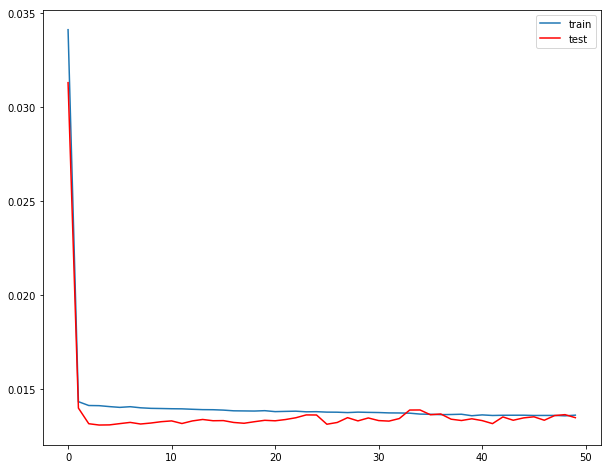

In [24]:
plt.figure(figsize=(10, 8));
plt.plot(history.history['loss'], label='train');
plt.plot(history.history['val_loss'], 'r-', label='test');
plt.legend();

# Evaluate Model

In [26]:
# Make a prediction
y_hat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# Invert scaling for forecast
inv_y_hat = concatenate((y_hat, test_X[:, 1:]), axis=1)
inv_y_hat = scaler.inverse_transform(inv_y_hat)
inv_y_hat = inv_y_hat[:,0]

# Invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# Calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_y_hat))
print('Test RMSE: %.3f' % rmse)

ValueError: Error when checking : expected lstm_2_input to have 3 dimensions, but got array with shape (8759, 8)